In [1]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from scipy.stats import norm
import pprint as pp
import yfinance as yf
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

plt.style.use('seaborn')
sns.set_palette('cubehelix')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
#Export stock ticker as list
df = pd.read_csv("ESG 30 stocks.csv", index_col=0)

TICKERS = df['Symbol'].tolist()
TICKERS.sort()
START_DATE = '2017-01-01'
END_DATE = '2022-01-01'

# data1 = data.DataReader(tickers,'yahoo', start_date, end_date)

prices_df = yf.download(TICKERS, start=START_DATE, 
                        end=END_DATE, adjusted=True)

adj_close_df = prices_df['Adj Close']

snp500 = yf.download('^GSPC', start=START_DATE,
                        end=END_DATE, adjusted=True)

snp500_adj_close = snp500['Adj Close']

[*********************100%***********************]  30 of 30 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
N_DAYS=252
N_ASSETS = len(TICKERS)
N_SIMULATION = 10**5

In [4]:
returns_df = adj_close_df.pct_change().dropna()
avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS

snp500_returns = snp500_adj_close.pct_change().dropna()
snp500_avg_returns = snp500_returns.mean() * N_DAYS

In [5]:
#Prepare weights
np.random.seed(0)
weights = np.random.random(size=(N_SIMULATION, N_ASSETS))
weights /=  np.sum(weights, axis=1)[:, np.newaxis]

#Calculate portfolio returns
portf_rtns = np.dot(weights, avg_returns)

#calculate Portfolio beta
#Calculate portfolio volatility
merged_portfolio = np.dot(weights,returns_df.T )

portf_beta = []
portf_vol = []
for candidate in merged_portfolio:
    beta = np.cov(candidate, snp500_returns,ddof = 1)[0][1]/ np.var(snp500_returns, ddof=1) 
    portf_beta.append(beta)
    portf_vol.append(np.std(candidate - beta*snp500_returns, ddof=1)* np.sqrt(N_DAYS) )


portf_beta = np.array(portf_beta)
portf_vol = np.array(portf_vol)  

#Calculate Sharpe Ratio
portf_sharpe_ratio = (portf_rtns - portf_beta*snp500_avg_returns) / portf_vol

#Create a dataframe to store the results
portf_results_df = pd.DataFrame({'returns': portf_rtns,
                                 'volatility': portf_vol,
                                 'sharpe_ratio': portf_sharpe_ratio})

In [6]:
N_POINTS = 100
portf_vol_ef = []
indices_to_skip = []

portf_rtns_ef = np.linspace(portf_results_df.returns.min(), 
                            portf_results_df.returns.max(), 
                            N_POINTS)
portf_rtns_ef = np.round(portf_rtns_ef, 2)    
portf_rtns = np.round(portf_rtns, 2)

for point_index in range(N_POINTS):
    if portf_rtns_ef[point_index] not in portf_rtns:
        indices_to_skip.append(point_index)
        continue
    matched_ind = np.where(portf_rtns == portf_rtns_ef[point_index])
    portf_vol_ef.append(np.min(portf_vol[matched_ind]))
    
portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

In [7]:
max_sharpe_ind = np.argmax(portf_results_df.sharpe_ratio)
max_sharpe_portf = portf_results_df.loc[max_sharpe_ind]

min_vol_ind = np.argmin(portf_results_df.volatility)
min_vol_portf = portf_results_df.loc[min_vol_ind]

In [8]:
print('Maximum Beta Adjusted Sharpe Ratio portfolio ----')
print('Performance')
for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(TICKERS, weights[np.argmax(portf_results_df.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Beta Adjusted Sharpe Ratio portfolio ----
Performance
returns: 32.67% volatility: 7.16% sharpe_ratio: 187.83% 
Weights
AAPL: 5.90% ACN: 5.95% AMP: 4.30% AMT: 6.77% ARE: 0.58% ASGN: 4.82% ASIX: 1.11% BCO: 4.69% CBT: 0.66% CC: 0.80% CDNS: 5.02% CRM: 3.66% EBAY: 2.35% FIVE: 3.36% FN: 4.91% FR: 5.04% FTNT: 6.99% HOLX: 0.27% JBHT: 6.99% KIM: 1.62% MATX: 3.54% MHK: 1.51% NKE: 5.20% NVDA: 6.09% ON: 0.13% SPG: 0.59% STM: 0.79% TEL: 2.05% WDAY: 3.87% WM: 0.46% 

In [9]:
print('Minimum Beta Volatility portfolio ----')
print('Performance')
for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(TICKERS, weights[np.argmin(portf_results_df.volatility)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Beta Volatility portfolio ----
Performance
returns: 28.76% volatility: 6.38% sharpe_ratio: 158.48% 
Weights
AAPL: 6.58% ACN: 4.90% AMP: 5.58% AMT: 6.17% ARE: 4.37% ASGN: 4.74% ASIX: 2.36% BCO: 0.67% CBT: 0.62% CC: 0.48% CDNS: 4.79% CRM: 6.84% EBAY: 6.78% FIVE: 0.95% FN: 1.92% FR: 3.66% FTNT: 1.55% HOLX: 5.29% JBHT: 0.69% KIM: 1.15% MATX: 2.19% MHK: 4.30% NKE: 6.03% NVDA: 1.52% ON: 3.81% SPG: 0.58% STM: 0.90% TEL: 4.95% WDAY: 1.56% WM: 4.07% 

In [10]:
#Create scatter plot coloured by Sharpe Ratio
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility',
                        y='returns', c='sharpe_ratio',
                        cmap='RdYlGn', edgecolors='black',
                        ax=ax)

ax.set(xlabel='Volatility',
        ylabel='Expected Returns',
        title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--')
ax.legend()

#plot red star to highlight position of portfolio with highest Sharpe Ratio
ax.scatter(x=max_sharpe_portf.volatility, y=max_sharpe_portf.returns,
                c='green', marker='*', s=500)

#plot green star to highlight position of minimum variance portfolio
ax.scatter(x=min_vol_portf.volatility, y=min_vol_portf.returns,
                c='red', marker='*', s=500)


plt.tight_layout()
# plt.savefig('images/ch7_im8.png')
plt.show()




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [11]:
import scipy.optimize as sco

In [12]:
def get_portf_rtn(w, avg_rtns):
    return np.sum(avg_rtns * w)

def get_portf_vol(w, avg_rtns, cov_mat,ret_df):
    merged_portfolio = np.dot(w,ret_df.T )
    beta = np.cov(merged_portfolio, snp500_returns,ddof=1)[0][1]/ np.var(snp500_returns, ddof=1) 
    return np.std(merged_portfolio - beta*snp500_returns, ddof=1)* np.sqrt(N_DAYS) 
    

def get_efficient_frontier(avg_rtns, cov_mat, rtns_range):
    
    efficient_portfolios = []
    
    n_assets = len(avg_rtns)
    args = (avg_rtns, cov_mat, returns_df)
    bounds = tuple((0,1) for asset in range(n_assets))
    initial_guess = n_assets * [1. / n_assets, ]
    
    for ret in rtns_range:
        constraints = ({'type': 'eq', 
                        'fun': lambda x: get_portf_rtn(x, avg_rtns) - ret},
                       {'type': 'eq', 
                        'fun': lambda x: np.sum(x) - 1})
        efficient_portfolio = sco.minimize(get_portf_vol, initial_guess, 
                                           args=args, method='SLSQP', 
                                           constraints=constraints,
                                           bounds=bounds)
        efficient_portfolios.append(efficient_portfolio)
    
    return efficient_portfolios

In [13]:
rtns_range = np.linspace(0.25, 0.37, 300)

efficient_portfolios = get_efficient_frontier(avg_returns, 
                                              cov_mat, 
                                              rtns_range)

In [14]:
vols_range = [x['fun'] for x in efficient_portfolios]
min_vol_ind = np.argmin(vols_range)
min_vol_portf_rtn = rtns_range[min_vol_ind]
min_vol_portf_vol = efficient_portfolios[min_vol_ind]['fun']
beta = np.cov(np.dot(efficient_portfolios[min_vol_ind]['x'],returns_df.T ), snp500_returns,ddof=1)[0][1]/ np.var(snp500_returns, ddof=1) 
min_vol_portf = {'Return': min_vol_portf_rtn,
                 'Volatility': min_vol_portf_vol,
                 'Sharpe Ratio': (min_vol_portf_rtn - beta*snp500_avg_returns)  / 
                                  (min_vol_portf_vol)}
                                 
                                
print('Minimum Beta Volatility portfolio ----')
print('Performance')

for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)

portfolio2={}
print('\nWeights')
for x, y in zip(TICKERS, efficient_portfolios[min_vol_ind]['x']):
    portfolio2[x]=y
    if y < 0.000001:
        continue
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Beta Volatility portfolio ----
Performance
Return: 28.81% Volatility: 4.95% Sharpe Ratio: 215.56% 
Weights
AAPL: 14.67% ACN: 10.12% AMP: 8.15% AMT: 4.51% ARE: 4.59% ASIX: 1.33% BCO: 1.30% CBT: 2.92% CDNS: 3.39% CRM: 4.43% EBAY: 3.73% FIVE: 1.11% FN: 0.72% FR: 2.56% FTNT: 0.51% HOLX: 4.18% JBHT: 4.28% KIM: 0.04% MATX: 1.12% MHK: 1.20% NKE: 3.71% NVDA: 2.93% SPG: 1.41% STM: 0.50% TEL: 3.48% WM: 13.14% 

In [15]:
def neg_sharpe_ratio(w, avg_rtns, cov_mat, rf_rate,rtns_df,snp500_rtns):
    portf_returns = np.sum(avg_rtns * w)
    
    merged_portfolio = np.dot(w,rtns_df.T )

    portf_beta = np.cov(merged_portfolio, snp500_rtns, ddof=1)[0][1]/np.var(snp500_rtns, ddof=1) 
    portf_volatility = np.std(merged_portfolio - portf_beta*snp500_rtns, ddof=1)* np.sqrt(N_DAYS) 
    
    portf_sharpe_ratio = (portf_returns - portf_beta*rf_rate) / portf_volatility
    return -portf_sharpe_ratio

RF_RATE = snp500_avg_returns   

args = (avg_returns, cov_mat, RF_RATE, returns_df, snp500_returns)
constraints = ({'type': 'eq', 
                'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0,1) for asset in range(N_ASSETS))
initial_guess = N_ASSETS * [1. / N_ASSETS]

max_sharpe_portf = sco.minimize(neg_sharpe_ratio, 
                                x0=initial_guess, 
                                args=args,
                                method='SLSQP', 
                                bounds=bounds, 
                                constraints=constraints)

In [16]:
max_sharpe_portf_w = max_sharpe_portf['x']
max_sharpe_portf = {'Return': get_portf_rtn(max_sharpe_portf_w, 
                                            avg_returns),
                    'Volatility': get_portf_vol(max_sharpe_portf_w, 
                                                avg_returns, 
                                                cov_mat,returns_df),
                    'Sharpe Ratio': -max_sharpe_portf['fun']}



In [17]:
print('Maximum Beta AdjustedSharpe Ratio portfolio ----')
print('Performance')

for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)

print('\nWeights')
portfolio4 = {}

all_tickers = pd.read_csv('ESG 30 stocks.csv')

all_tickers = all_tickers.Symbol.tolist()
all_tickers.sort()
for k in all_tickers:
    portfolio4[k] = 0

for x, y in zip(TICKERS, max_sharpe_portf_w):
    if y < 0.000001:
        continue
    portfolio4[x]=y
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)
    

Maximum Beta AdjustedSharpe Ratio portfolio ----
Performance
Return: 34.22% Volatility: 5.96% Sharpe Ratio: 263.82% 
Weights
AAPL: 16.92% ACN: 11.47% AMP: 6.18% AMT: 6.86% ARE: 0.26% ASGN: 0.57% ASIX: 1.99% BCO: 0.91% CDNS: 6.49% CRM: 0.08% EBAY: 2.11% FIVE: 4.13% FN: 0.46% FR: 4.37% FTNT: 5.80% JBHT: 2.85% KIM: 0.19% MATX: 2.24% NKE: 5.08% NVDA: 5.00% ON: 1.05% TEL: 1.33% WM: 13.64% 

In [18]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.plot(vols_range, rtns_range, 'b--', linewidth=3)
ax.set(xlabel='Volatility', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')

#plot green star to highlight position of portfolio with highest Sharpe Ratio
ax.scatter(x=max_sharpe_portf['Volatility'], y=max_sharpe_portf['Return'],
                c='green', marker='*', s=500)

#plot red star to highlight position of minimum variance portfolio
ax.scatter(x=min_vol_portf['Volatility'], y=min_vol_portf['Return'],
                c='red', marker='*', s=500)


plt.tight_layout()
plt.show()

In [19]:
# import csv
# with open('Portfolio 4min.csv', 'w') as f:
#     for key in portfolio2.keys():
#         f.write("%s,%s\n"%(key,portfolio2[key]))

# import pandas as pd
# df = pd.read_csv('Portfolio 4min.csv', header=None)
# df.columns = ['Asset', 'Weight']
# df.to_csv('Portfolio 4min.csv', index=False)
# df.to_excel('Portfolio 3.xlsx', index=False)

In [20]:
# import csv
# with open('Portfolio 4.csv', 'w') as f:
#     for key in portfolio4.keys():
#         f.write("%s,%s\n"%(key,portfolio4[key]))

# import pandas as pd
# df = pd.read_csv('Portfolio 4.csv', header=None)
# df.columns = ['Asset', 'Weight']
# df.to_csv('Portfolio 4.csv', index=False)
# df.to_excel('Portfolio 3.xlsx', index=False)

In [21]:
import pyfolio as pf
x = adj_close_df.pct_change().dropna()
y = max_sharpe_portf_w
# y = efficient_portfolios[min_vol_ind]['x']
z = x * y
weighted_portfolio = z.sum(axis = 1)


c:\Users\juans\anaconda3\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [22]:
#calculate beta against S&P 500
sp500_df = yf.download('^GSPC', start=START_DATE,
                       end=END_DATE, adjusted=True)
sp500_df = sp500_df['Adj Close'].pct_change().dropna()

#create a dataframe with the portfolio and S&P 500
beta_portfolio_df = pd.DataFrame({'Portfolio': weighted_portfolio,
                                    'S&P 500': sp500_df})

#calculate correlation
corr = beta_portfolio_df.corr().iloc[0,1]
print(f'Correlation: {corr:.6f}')


# #calculate beta
covar = beta_portfolio_df.cov().iloc[0,1]
varSnP = beta_portfolio_df['S&P 500'].var()
beta = covar / varSnP

print(f'Beta: {beta:.6f}')




vari = (weighted_portfolio  - beta* sp500_df).std() 
sharpe_portfolio5 = ((weighted_portfolio.mean() - beta*sp500_df.mean())/ vari)*np.sqrt(252)
print("*****Beta Adjusted Sharpe Ratio of Portfolio4**** :\n", sharpe_portfolio5.round(4))

[*********************100%***********************]  1 of 1 completed
Correlation: 0.962599
Beta: 1.099823
*****Beta Adjusted Sharpe Ratio of Portfolio4**** :
 2.6382


In [23]:
beta_adjusted_sharpe_portfolio4 = ((weighted_portfolio.mean() - beta*sp500_df.mean())/ weighted_portfolio.std())*np.sqrt(252)
print("*****Beta Adjusted Sharpe Ratio of Portfolio4**** :\n", beta_adjusted_sharpe_portfolio4.round(4))

*****Beta Adjusted Sharpe Ratio of Portfolio4**** :
 0.7148


In [24]:
#plot the returns
# portfolio_returns_pyfolio.plot()

pf.create_simple_tear_sheet(weighted_portfolio)

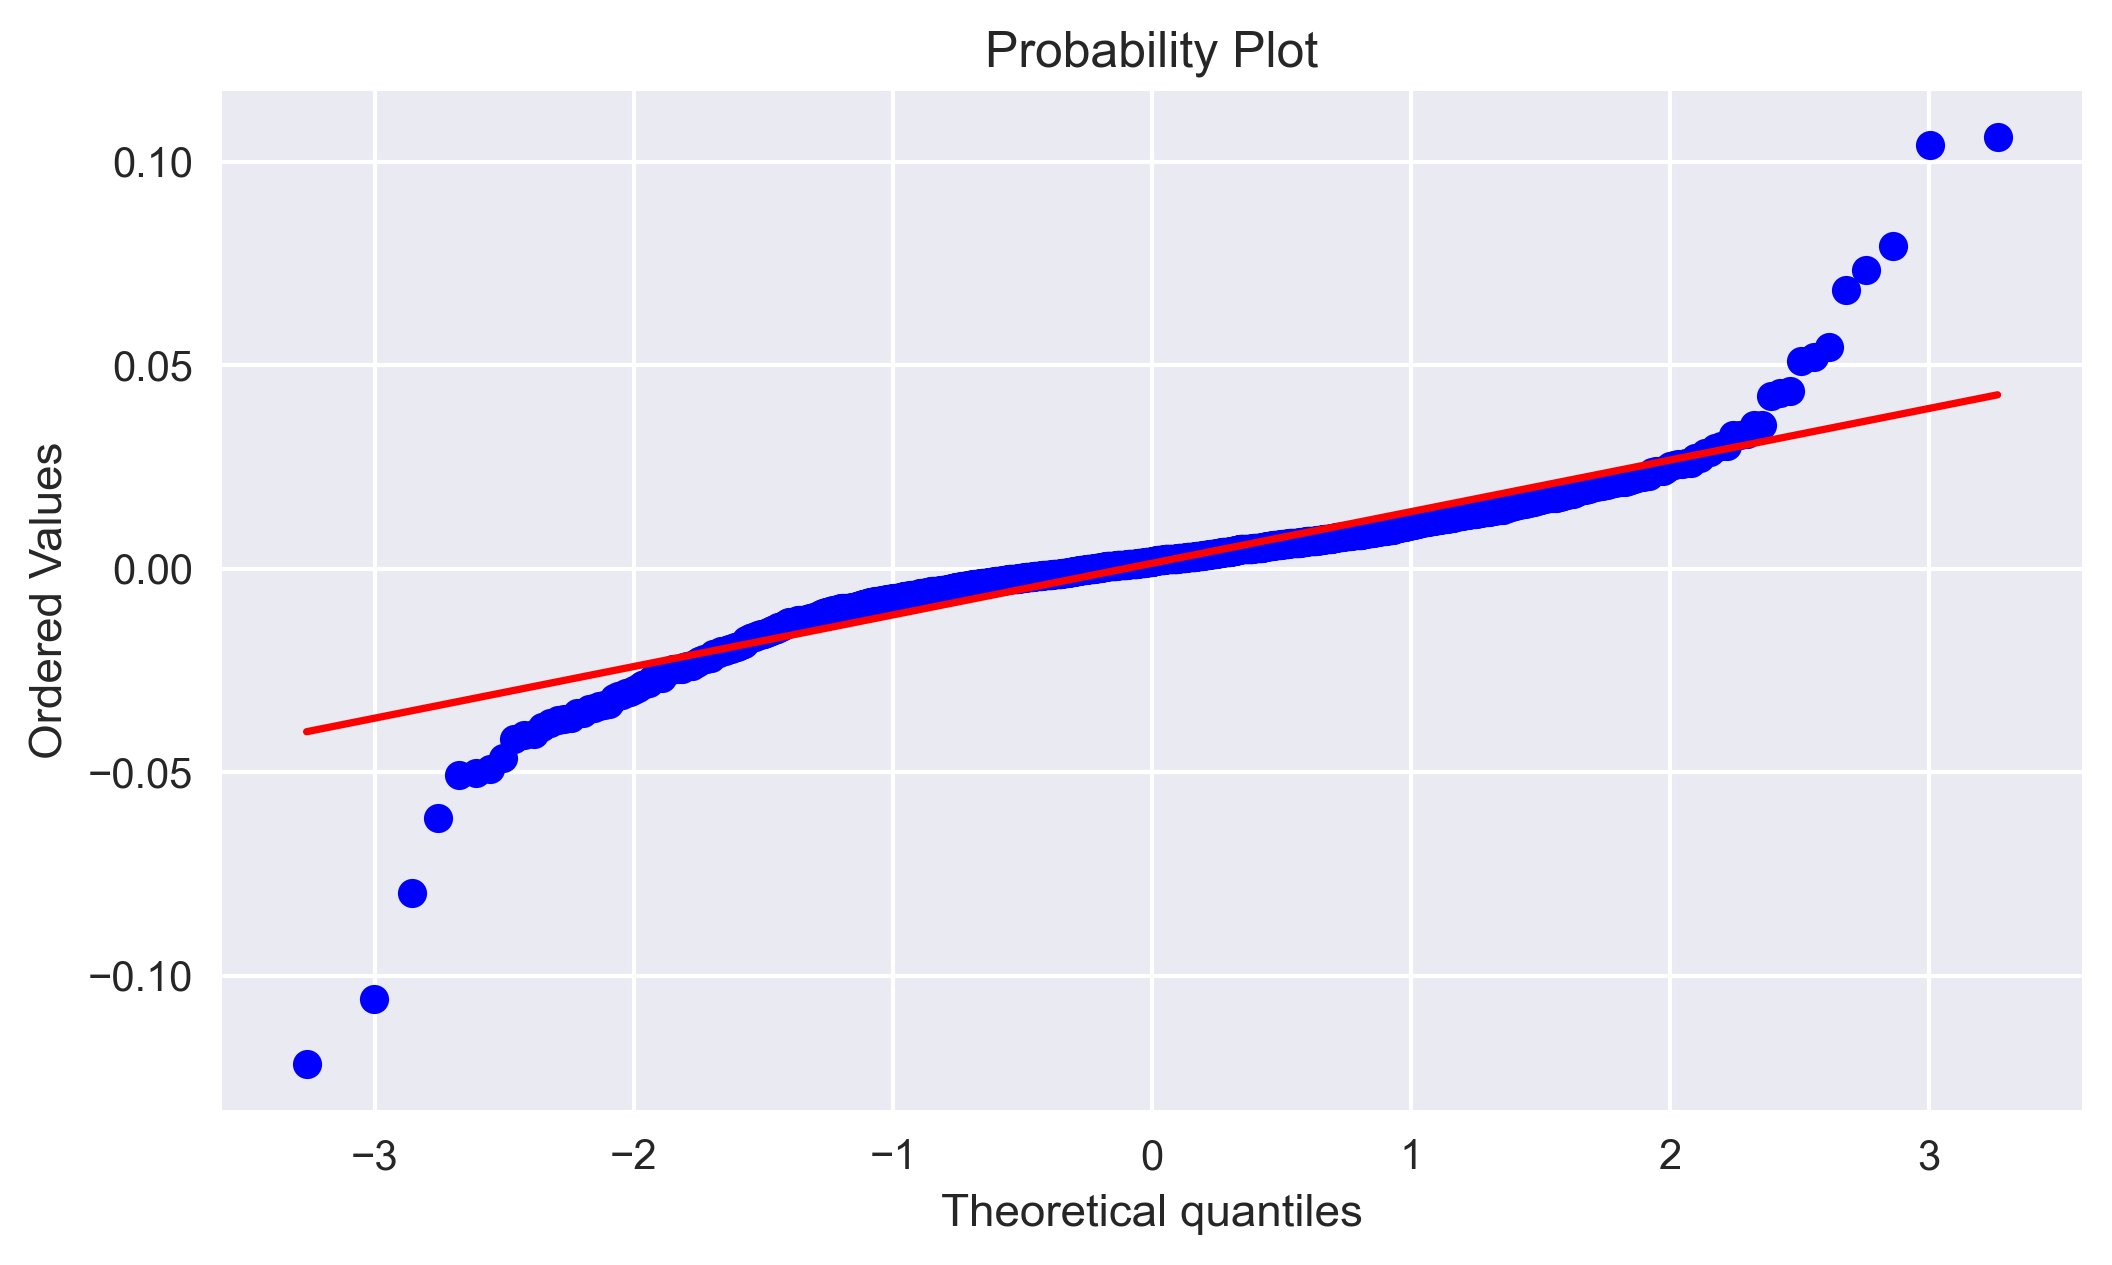

In [25]:
#Create qq plot for pct_change
import scipy.stats as stats
import pylab
stats.probplot(weighted_portfolio, dist="norm", plot=pylab)
pylab.show()
